# Lunar Lander - Image

## Imports

In [37]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

K.set_image_data_format('channels_first')

import warnings
warnings.filterwarnings("ignore")

## Preparing the Data
Load the raw image dataset and pre-process it. Divide this into train and test splits. Balance the training split.

### Load Images

Loads a set of images and resizes each image to 64x64 and coverts to black and white. 

In [38]:
# Set up some parmaeters for data loading
TRAIN_DIR = './data/'
sample_rate = 0.2
ROWS = 84
COLS = 84
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 12864
Processed 1000 of 12864
Processed 2000 of 12864
Processed 3000 of 12864
Processed 4000 of 12864
Processed 5000 of 12864
Processed 6000 of 12864
Processed 7000 of 12864
Processed 8000 of 12864
Processed 9000 of 12864
Processed 10000 of 12864
Processed 11000 of 12864
Processed 12000 of 12864
Train shape: (12864, 1, 84, 84)


### Stacking Images

In [39]:
#for every frame the pervious 2 frames are considered as context
CHANNELS2=3
ROWS2=84
COLS2=84
N_Frames=3
data2 = np.ndarray((count,CHANNELS2, ROWS2, COLS2), dtype=np.float)
#combining frames from data to data
for i in range(count):
    if i==0:
        temp=np.stack([data[i],data[i],data[i]])
        #temp=temp/255
    if i==1:
        temp=np.stack([data[i],data[i-1],data[i-1]])
        #temp =temp/255
    if i==2:
        temp=np.stack([data[i],data[i-1],data[i-2]])
        #temp = temp/255
    else:
        temp = np.stack([data[i],data[i-1],data[i-2]])
        #temp=temp/255
    
    data2[i]=temp.reshape(3,84,84)

### Generating the Labels

We're dealing with a multi-class classification problem here - (0) no action, (1) left, (2) up, and (3) right. The lables can be created by looping over the file names in the train directory.

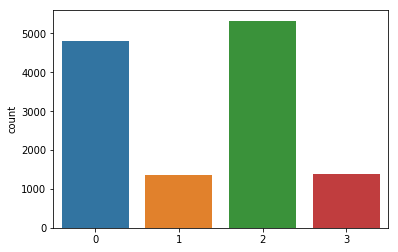

In [40]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
sns.countplot(labels)

### Show some screens
Print a few screens with their labels.

3


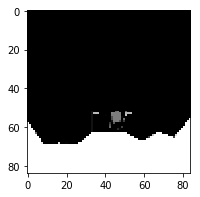

3


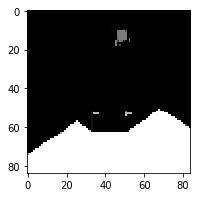

2


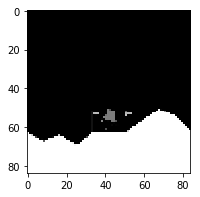

0


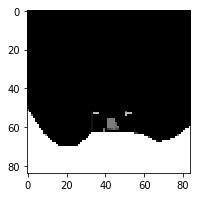

3


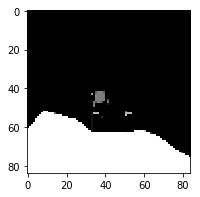

In [41]:
for i in range(0,5):
    idx = random.randint(0, len(labels))
    print(labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(data[idx][0], cmap='gray')
    plt.show()

### Partition the dataset for evaluation
Split the data into a training and test partition so we can evaluate at the end

In [42]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

Apply under sampling to balance the training dataset

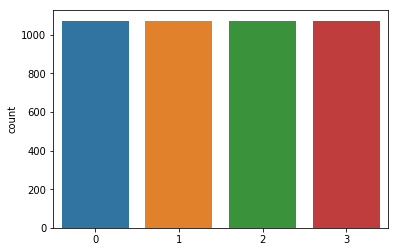

In [43]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

### Show some screens
Print a few screens with their labels.

Data

3


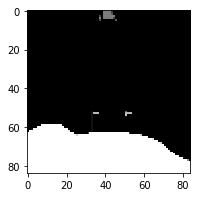

2


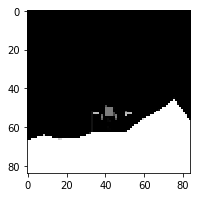

2


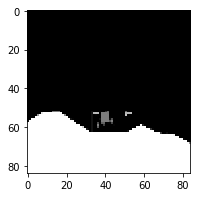

3


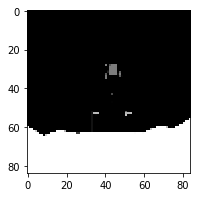

2


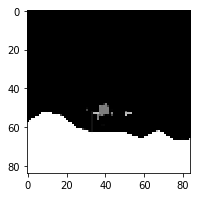

In [44]:
for i in range(0,5):
    idx = random.randint(0, len(labels))
    print(labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(data[idx][0], cmap='gray')
    plt.show()

Train

1


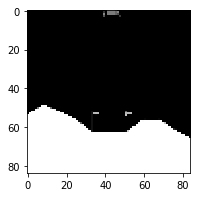

0


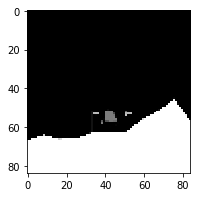

0


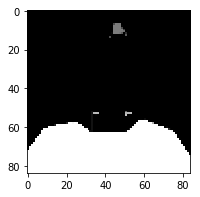

0


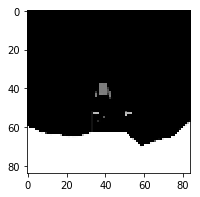

0


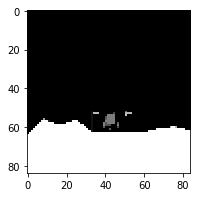

In [45]:
for i in range(0,5):
    idx = random.randint(0, len(train_labels))
    print(train_labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(train[idx][0], cmap='gray')
    plt.show()

Train resampled

1


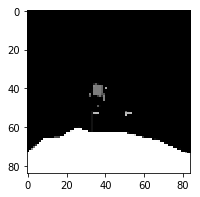

2


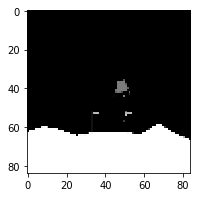

1


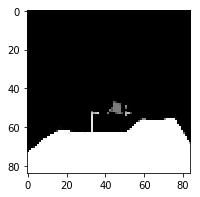

2


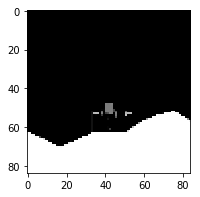

0


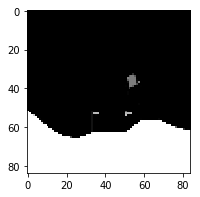

In [46]:
for i in range(0,5):
    idx = random.randint(0, len(train_labels_rus))
    print(train_labels_rus[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(train_rus[idx][0], cmap='gray')
    plt.show()

Test

0


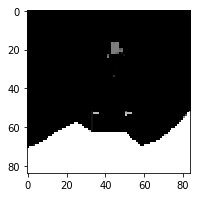

3


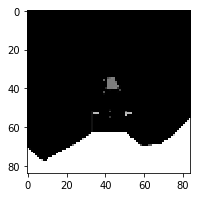

2


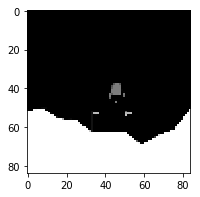

3


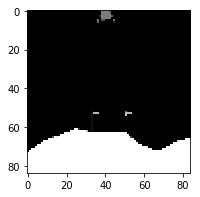

2


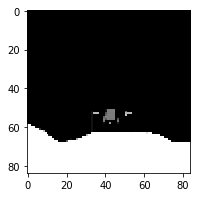

In [47]:
for i in range(0,5):
    idx = random.randint(0, len(test_labels))
    print(test_labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(test[idx][0], cmap='gray')
    plt.show()

## LunarLanderNet

A simple convolutional network to control the lander.

In [48]:
model = Sequential()
model.add(Conv2D(32, (8, 8),strides=4,input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(64, (4, 4), strides=2,activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(64, (3, 3), strides=1,activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 20, 20)        2080      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 10, 10)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 32, 10, 10)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 5, 5)          32832     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 64, 2, 2)          0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 64, 2, 2)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 64, 2, 2)          36928     
__________

In [49]:
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

### Train
Train a model.

In [50]:
epochs = 50
batch_size = 128

history = model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 3219 samples, validate on 1073 samples
Epoch 1/50
3219/3219 [==============================] - 8s 3ms/step - loss: 1.3883 - acc: 0.2613 - val_loss: 1.3859 - val_acc: 0.2414
Epoch 2/50
3219/3219 [==============================] - 7s 2ms/step - loss: 1.3865 - acc: 0.2355 - val_loss: 1.3822 - val_acc: 0.2665
Epoch 3/50
3219/3219 [==============================] - 6s 2ms/step - loss: 1.3633 - acc: 0.3253 - val_loss: 1.2875 - val_acc: 0.3914
Epoch 4/50
3219/3219 [==============================] - 7s 2ms/step - loss: 1.2824 - acc: 0.3827 - val_loss: 1.2329 - val_acc: 0.4110
Epoch 5/50
3219/3219 [==============================] - 7s 2ms/step - loss: 1.2373 - acc: 0.4147 - val_loss: 1.1913 - val_acc: 0.4091
Epoch 6/50
3219/3219 [==============================] - 8s 2ms/step - loss: 1.2031 - acc: 0.4284 - val_loss: 1.1555 - val_acc: 0.4418
Epoch 7/50
3219/3219 [==============================] - 8s 2ms/step - loss: 1.1723 - acc: 0.4418 - val_loss: 1.1144 - val_acc: 0.4846
Epoch 8/50
321

Plot the evolution of the loss as the module was trained.

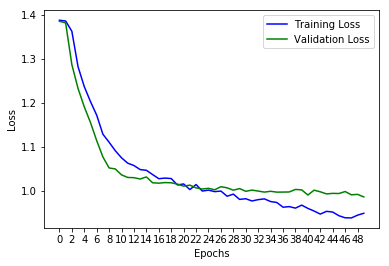

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')

plt.xticks(range(0,epochs)[0::2])
plt.legend()

plt.show()

### Evaluate the Model
Use the test dataset to evaluate the model

In [52]:
print("****** Simple Model ********")
# Make a set of predictions for the test data
pred = model.predict_classes(test)

# Print performance details for the simple model
accuracy = metrics.accuracy_score(test_labels, pred)
print("Accuracy: " +  str(accuracy))

# Print classification report
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))

****** Simple Model ********
Accuracy: 0.4430625728721337
             precision    recall  f1-score   support

          0       0.44      0.60      0.51       946
          1       0.41      0.59      0.49       276
          2       0.51      0.18      0.27      1042
          3       0.42      0.71      0.53       309

avg / total       0.46      0.44      0.41      2573

Confusion Matrix
[[568 106 142 130]
 [ 83 163  16  14]
 [572 120 189 161]
 [ 59   5  25 220]]


### Grid Search to Find Suitable Hyper-Parameters

In [53]:
# Function to create & compile the model
def cnn_model(layer1=32, layer2=64, layer3=64, layer4=512):
    model = Sequential()
    
    model.add(Conv2D(layer1, (8, 8),strides=4,input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))


    model.add(Conv2D(layer2, (4, 4), strides=2,activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))


    model.add(Conv2D(layer3, (3, 3), strides=1,activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(layer4, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model

# Define the model
model = KerasClassifier(build_fn=cnn_model, epochs=50, batch_size=128, verbose=1)

# Define the parameter grid
layer1 = [32,64]
layer2 = [64,128]
layer3 = [64,128]
layer4 = [512]

param = dict(layer1=layer1, layer2=layer2, layer3=layer3, layer4=layer4)

# Grid search
clf = GridSearchCV(estimator=model, param_grid=param, cv=2, verbose=1)
clf.fit(train_rus, train_labels_rus_wide)

# Prints the best set of hyper-parameters
print(clf.best_score_)
print(clf.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/50
2146/2146 [==============================] - 5s 2ms/step - loss: 1.3870 - acc: 0.2502
Epoch 2/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.3863 - acc: 0.2554
Epoch 3/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.3843 - acc: 0.2637
Epoch 4/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.3757 - acc: 0.3141
Epoch 5/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.3263 - acc: 0.3639
Epoch 6/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.2595 - acc: 0.4096
Epoch 7/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.2235 - acc: 0.4268
Epoch 8/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.2061 - acc: 0.4292
Epoch 9/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.1823 - acc: 0.4557
Epoch 10/50
2146/2146 [==============================] - 4s 2ms/ste

Epoch 33/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9809 - acc: 0.5485
Epoch 34/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9715 - acc: 0.5513
Epoch 35/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9543 - acc: 0.5531
Epoch 36/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9751 - acc: 0.5494
Epoch 37/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9686 - acc: 0.5545
Epoch 38/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9652 - acc: 0.5480
Epoch 39/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9629 - acc: 0.5568
Epoch 40/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9612 - acc: 0.5494
Epoch 41/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9559 - acc: 0.5615
Epoch 42/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9687 - acc: 0.5527
Epoch 43/50
2146/214

2146/2146 [==============================] - 4s 2ms/step - loss: 0.9197 - acc: 0.5634
Epoch 47/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.9112 - acc: 0.5727
Epoch 48/50
2146/2146 [==============================] - 5s 2ms/step - loss: 0.8948 - acc: 0.5923
Epoch 49/50
2146/2146 [==============================] - 4s 2ms/step - loss: 0.8908 - acc: 0.5774
Epoch 50/50
2146/2146 [==============================] - 2s 1ms/step
Epoch 1/50
2146/2146 [==============================] - 6s 3ms/step - loss: 1.3894 - acc: 0.2512
Epoch 2/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.3848 - acc: 0.2651
Epoch 3/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.3782 - acc: 0.2852
Epoch 4/50
2146/2146 [==============================] - 5s 2ms/step - loss: 1.3288 - acc: 0.3611
Epoch 5/50
2146/2146 [==============================] - 4s 2ms/step - loss: 1.2659 - acc: 0.4040
Epoch 6/50
2146/2146 [==============================] - 4s 2ms/ste

2146/2146 [==============================] - 7s 3ms/step - loss: 1.1796 - acc: 0.4571
Epoch 9/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.1547 - acc: 0.4511
Epoch 10/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.1263 - acc: 0.4697
Epoch 11/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.1057 - acc: 0.4856
Epoch 12/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.0880 - acc: 0.4995
Epoch 13/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.0728 - acc: 0.5028
Epoch 14/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.0698 - acc: 0.5051
Epoch 15/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.0606 - acc: 0.4991
Epoch 16/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.0434 - acc: 0.5061
Epoch 17/50
2146/2146 [==============================] - 7s 3ms/step - loss: 1.0420 - acc: 0.5098
Epoch 18/50
2146/2146 [==========

2146/2146 [==============================] - 7s 3ms/step - loss: 0.9896 - acc: 0.5377
Epoch 22/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9857 - acc: 0.5345
Epoch 23/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9797 - acc: 0.5377
Epoch 24/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9720 - acc: 0.5545
Epoch 25/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9643 - acc: 0.5480
Epoch 26/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9641 - acc: 0.5527
Epoch 27/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9503 - acc: 0.5517
Epoch 28/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9488 - acc: 0.5582
Epoch 29/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9431 - acc: 0.5652
Epoch 30/50
2146/2146 [==============================] - 7s 3ms/step - loss: 0.9301 - acc: 0.5606
Epoch 31/50
2146/2146 [=========

2146/2146 [==============================] - 8s 4ms/step - loss: 0.8704 - acc: 0.5867
Epoch 35/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8600 - acc: 0.6100
Epoch 36/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8627 - acc: 0.6048
Epoch 37/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8409 - acc: 0.6114
Epoch 38/50
2146/2146 [==============================] - 9s 4ms/step - loss: 0.8324 - acc: 0.6016
Epoch 39/50
2146/2146 [==============================] - 9s 4ms/step - loss: 0.8250 - acc: 0.6146
Epoch 40/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8194 - acc: 0.6179
Epoch 41/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8104 - acc: 0.6319
Epoch 42/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8111 - acc: 0.6300
Epoch 43/50
2146/2146 [==============================] - 8s 4ms/step - loss: 0.8036 - acc: 0.6403
Epoch 44/50
2146/2146 [=========

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 81.3min finished


Epoch 1/50
4292/4292 [==============================] - 11s 3ms/step - loss: 1.3882 - acc: 0.2439
Epoch 2/50
4292/4292 [==============================] - 8s 2ms/step - loss: 1.3622 - acc: 0.3201
Epoch 3/50
4292/4292 [==============================] - 8s 2ms/step - loss: 1.2469 - acc: 0.3982
Epoch 4/50
4292/4292 [==============================] - 8s 2ms/step - loss: 1.1778 - acc: 0.4413
Epoch 5/50
4292/4292 [==============================] - 10s 2ms/step - loss: 1.1306 - acc: 0.4690
Epoch 6/50
4292/4292 [==============================] - 9s 2ms/step - loss: 1.0888 - acc: 0.4923
Epoch 7/50
4292/4292 [==============================] - 10s 2ms/step - loss: 1.0748 - acc: 0.4874
Epoch 8/50
4292/4292 [==============================] - 11s 3ms/step - loss: 1.0639 - acc: 0.5037
Epoch 9/50
4292/4292 [==============================] - 10s 2ms/step - loss: 1.0438 - acc: 0.5033
Epoch 10/50
4292/4292 [==============================] - 10s 2ms/step - loss: 1.0489 - acc: 0.5035
Epoch 11/50
4292/4292 [

### Evaluate the Tuned Model

In [54]:
# Define the model
model = Sequential()

model.add(Conv2D(32, (8, 8),strides=4,input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(64, (4, 4), strides=2,activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(128, (3, 3), strides=1,activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 32, 20, 20)        2080      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 32, 10, 10)        0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 32, 10, 10)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 64, 5, 5)          32832     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 64, 2, 2)          0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 64, 2, 2)          0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 128, 2, 2)         73856     
__________

In [55]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

In [56]:
# Train the model
epochs = 50
batch_size = 128

history = model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 3219 samples, validate on 1073 samples
Epoch 1/50
3219/3219 [==============================] - 9s 3ms/step - loss: 1.3899 - acc: 0.2479 - val_loss: 1.3860 - val_acc: 0.2898
Epoch 2/50
3219/3219 [==============================] - 7s 2ms/step - loss: 1.3816 - acc: 0.2780 - val_loss: 1.3672 - val_acc: 0.3318
Epoch 3/50
3219/3219 [==============================] - 7s 2ms/step - loss: 1.3188 - acc: 0.3545 - val_loss: 1.2509 - val_acc: 0.3952
Epoch 4/50
3219/3219 [==============================] - 8s 2ms/step - loss: 1.2526 - acc: 0.4035 - val_loss: 1.1903 - val_acc: 0.4250
Epoch 5/50
3219/3219 [==============================] - 7s 2ms/step - loss: 1.1953 - acc: 0.4321 - val_loss: 1.1502 - val_acc: 0.4800
Epoch 6/50
3219/3219 [==============================] - 8s 3ms/step - loss: 1.1561 - acc: 0.4570 - val_loss: 1.1069 - val_acc: 0.4874
Epoch 7/50
3219/3219 [==============================] - 8s 2ms/step - loss: 1.1219 - acc: 0.4787 - val_loss: 1.0608 - val_acc: 0.4884
Epoch 8/50
321

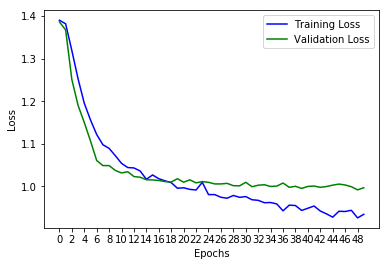

In [57]:
# Plot the evolution of the loss as the model was trained
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')

plt.xticks(range(0,epochs)[0::2])
plt.legend()

plt.show()

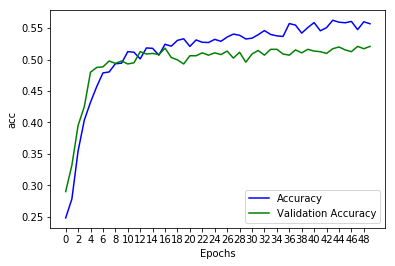

In [58]:
# Plot the evolution of the accuracy as the model was trained
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')

plt.plot(acc, 'blue', label='Accuracy')
plt.plot(val_acc, 'green', label='Validation Accuracy')

plt.xticks(range(0,epochs)[0::2])
plt.legend()

plt.show()

In [59]:
print("****** Tuned Model  ********")
# Make a set of predictions for the test data
pred = model.predict_classes(test)

# Print performance details for the tuned model
accuracy = metrics.accuracy_score(test_labels, pred)
print("Accuracy: " +  str(accuracy))

#Print classification report
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))

****** Tuned Model  ********
Accuracy: 0.44889234356781965
             precision    recall  f1-score   support

          0       0.43      0.73      0.55       946
          1       0.44      0.58      0.50       276
          2       0.50      0.11      0.18      1042
          3       0.48      0.61      0.54       309

avg / total       0.47      0.45      0.39      2573

Confusion Matrix
[[693  87  89  77]
 [ 94 161  16   5]
 [703 105 113 121]
 [105   9   7 188]]


### Persist A Model
Save the model

In [60]:
filepath = "player_images_2.mod"
model.save(filepath)

Load a saved model

In [61]:
model = keras.models.load_model("player_images_2.mod")